# DGRF candidates 

Load available candidates

Use the alphebetical ordering and labels from each candidate.

There is a set naming convention: 
- first three lines start with # 
- third line has: g h       n           m      n_uncertainty m_uncertainty
- data starts on fourth line e.g.:   1  0 -29441.40      0.00            0.00            0.00

Tests are:

0) Check files are correctly formatted, then:
1) Lowes-Maursberger power spectra plot
2) RMS differences between coefficients table and plot  
3) Degree correlation between coefficients and one chosen model
4) Azimuthal spectra between coefficients and one chosen model
5) Triangle plot of differences between coefficients and one chosen model
6) Maps magnetic field in: X, Y, Z, Br, Bt, Bp between coefficients and one chosen model


In [1]:
# Import the packages and bespoke functions from src folder
import os
import sys
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append('..')

import shapefile  # from package pyshp >= 2.3.1, pip install pyshp
shp = os.path.abspath('../data/external/ne_110m_coastline.zip')

from src import sha_lib as shal
from src import shc_utils as shau

# Set up line colour/type/marker properties using cycler
from cycler import cycler
cc = ( cycler(linestyle=['-', '--', '-.',':']) *
       cycler(color=list('rgbk')) *
       cycler(marker=['none', 's', '.']))

## Configure input

User sets the following variables:

In [2]:
# Access candidate models in the ../data/IGRF13/DGRF directory
# Declare the fixed constants
field_type = 'main'   # 'main' or 'sv'
candidate = 'DGRF'    # 'DGRF', 'IGRF' or 'SV'
year = '2020'         # For labelling

DGRF_DIR = os.path.abspath('../data/coefficients/' + candidate + '/*.cof')

# Choose a model from the candidate list to compare the others against using its filename e.g.
# The Median version was chosen for the DGRF final model
compare_against = 'IGRF13'

In [3]:
"""

Check files are correctly formatted

"""
print('List of ' + candidate + ' Candidates \n ----------- ')
files = sorted(glob.glob(DGRF_DIR))
print(*files, sep='\n')

pass_or_fail = shau.check_cof_file_format(files, field_type)

if not(pass_or_fail).all():
    raise Exception('A candidate model format is incorrect. Fix it before \
                    continuing')

# Load in the coefficients - define the type (main or sv) and the leading
# acronym on the filename
[coeffs, institute_name, degree] = \
         shau.load_coeffs_to_numpy(sorted(files), field_type, candidate)
num_candidates = coeffs.shape[1]

List of DGRF Candidates 
 ----------- 
/home/runner/work/IGRF14eval/IGRF14eval/data/coefficients/DGRF/DGRF_IGRF13.cof


## Power spectra

Text(0.5, 1.0, 'Mausberger-Lowes Spectrum for DGRF 2020 candidates')

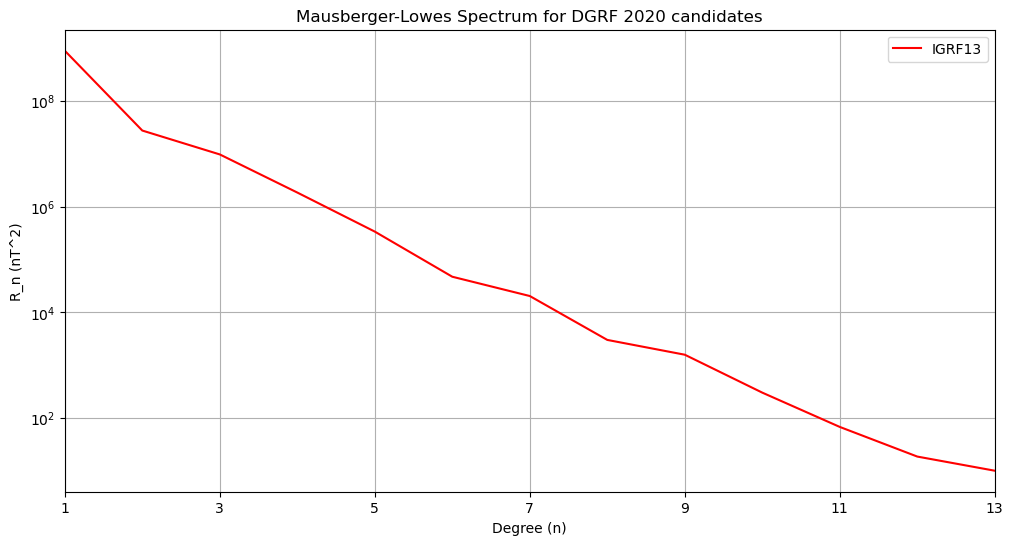

In [4]:
"""

First Test: plot of power spectra of each model on a log plot (n versus Rn)

"""

# Set up figure and line colour/type using cycler
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_prop_cycle(cc)

# Place the Rn values and institute names in a dictionary
Rn = []
for i in range(num_candidates):
    Rn.append(shau.msum(coeffs[:,i], degree))
spectra = dict(zip(institute_name, Rn))

# Plotting the lines with labels
for label, y in spectra.items():
   ax.semilogy(np.arange(1, degree+1), y, label = label)
# Adding legend, x and y labels, and title for the lines
ax.legend()
plt.xlabel('Degree (n)')
plt.ylabel('R_n (nT^2)')
ax.grid()
plt.xticks(np.arange(1, degree+1,2))
plt.xlim(1,degree)
plt.title('Mausberger-Lowes Spectrum for ' + candidate +
          ' ' + year + ' candidates')



## RMS differences

RMS Difference between DGRF 2020 candidates
  0.0


ValueError: zero-size array to reduction operation maximum which has no identity

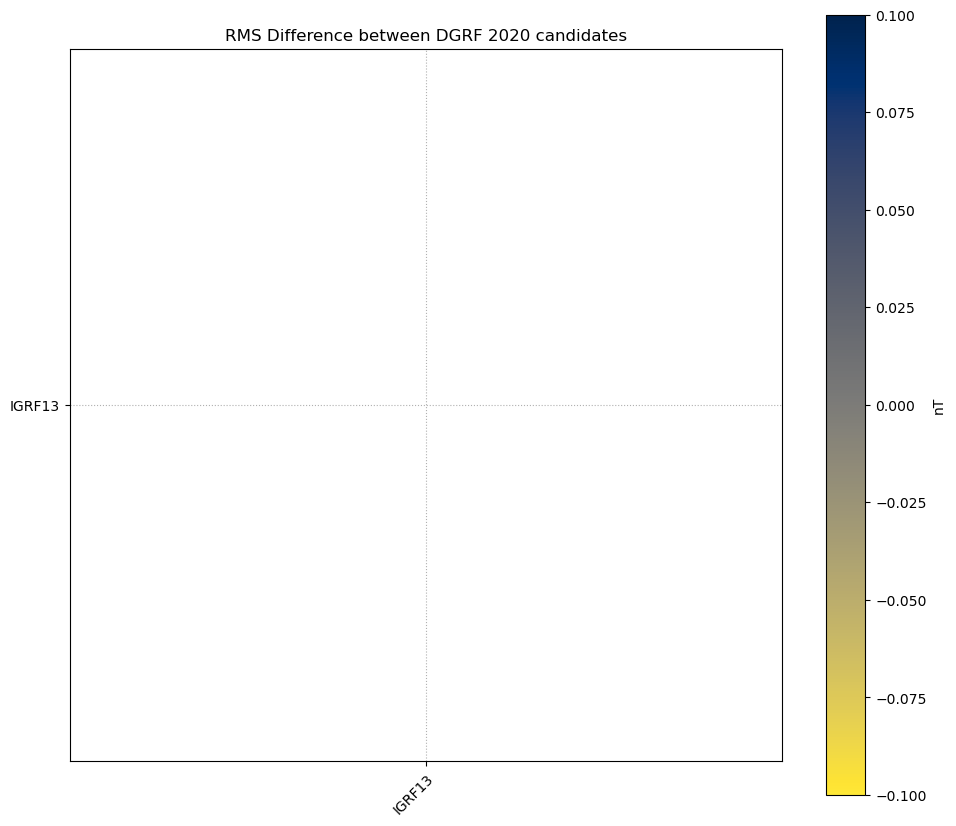

In [5]:
"""

Second Test: plot of RMS difference between each model (dP)

"""

# filling dP with NaN values makes the imshow plot background white
dP = np.full((num_candidates,num_candidates),np.nan)
for i in range(num_candidates):
    for j in range(i+1,num_candidates):
        dP[i,j] = np.sqrt(
                    np.sum(
                    np.multiply(
                    np.arange(2,degree+2),
                    shau.msumnsq( (coeffs[:,i] - coeffs[:,j])**2, degree) )))

# Print to screen two decimal places
print('RMS Difference between ' + candidate + ' ' + year + ' candidates')
pdP = dP.copy()
pdP[np.isnan(pdP)]=0
for i in np.around(pdP,2):
    print(" ".join([str(l).rjust(5) for l in i]))

fig, ax = plt.subplots(figsize=(10, 10))
plt.subplots_adjust(top=0.91, bottom=0.13, left=0.075, right=0.965)
im = plt.imshow(dP, cmap='cividis_r')

# Place labels on x and y alternately
plt.xticks(np.arange(0, num_candidates,1))
ax.set_xticklabels(institute_name)
plt.yticks(np.arange(0, num_candidates,1))
ax.set_yticklabels(institute_name)
ax.grid(True, ls=':')
plt.colorbar(label='nT')
plt.title('RMS Difference between ' + candidate + ' ' + year + ' candidates')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
valfmt = mpl.ticker.StrMethodFormatter('{x:.1f}')
threshold = im.norm(dP[~np.isnan(dP)].max())/2.
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors=("black", "white")
for i in range(num_candidates):
    for j in range(i+1,num_candidates):
        kw.update(color=textcolors[int(im.norm(dP[i, j]) > threshold)])
        text = ax.text(j, i, valfmt(dP[i, j]), **kw)

## RMS differences per degree

In [ ]:
"""

Third Test: plot of RMS difference per degree between each model (dP_degree)
          : and the degree correlation in the same loop (dC_degree)

"""

dP_degree = []
dC_degree = []

# Find the requested model position (pos) in the file list
pos = np.array([i for i, elem in enumerate(files) if compare_against in elem])

for j in range(num_candidates):

        dP_degree.append( np.multiply(
                    np.arange(2,degree+2),
                    shau.msumnsq( (coeffs[:,pos[0]] - coeffs[:,j])**2, degree)
                    ) )

        dC_degree.append(np.divide(
                          shau.msumnsq(
                          np.multiply(coeffs[:,pos[0]], coeffs[:,j]), degree),
                          np.sqrt( np.multiply(
                              shau.msumnsq( coeffs[:, pos[0]]**2, degree),
                              shau.msumnsq( coeffs[:, j]**2, degree  ) ) )
                          ) )


degree_diff = dict(zip(institute_name, dP_degree))
degree_corr =  dict(zip(institute_name, dC_degree))

# Remove the candidate that we're comparing against using the institute name in
# key value in the dict
degree_diff.pop(compare_against)
degree_corr.pop(compare_against)

# Set up figure and line colour/type using cycler
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax1.set_prop_cycle(cc)
ax2.set_prop_cycle(cc)

# Plotting the dP_degree
for label, y in degree_diff.items():
   ax1.semilogy(np.arange(1, degree+1), y, label = label)
# Adding, x and y labels, and title for the lines
plt.xlabel('Degree (n)')
ax1.set_ylabel('nT^2')
ax1.grid()
ax1.set_title('Mean Square Difference per degree between ' + compare_against +
              ' / '+ candidate + ' ' + year + ' candidates')

# Plotting the dC_degree
for label, y in degree_corr.items():
   ax2.plot(np.arange(1, degree+1), y, label = label)
# Adding, x and y labels, and title for the lines
plt.xlabel('Degree (n)')
ax2.set_ylabel('Correlation')
ax2.grid()
ax2.set_title('Degree correlation between Candidate '+ compare_against +
              ' / ' + candidate + ' ' + year + ' candidates')
ax2.legend(ncols=2, loc=3)
plt.xticks(np.arange(1, degree+1, 2))
plt.xlim(1,degree)

## Azimuthal power spectra

In [ ]:
"""

Fourth Test: Plot the azimuthal power spectrum of each candidate

Based on the example from E. Thebault

"""

# Set up figure and line colour/type using cycler
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_prop_cycle(cc)

# Place the Rn values and institute names in a dictionary
Az = []
for j in range(num_candidates):
    xa, ra = shau.ra_spectrum(degree,1, 1/(degree+1),
                              (coeffs[:,pos[0]] - coeffs[:,j]))
    Az.append(ra)
az_spectra = dict(zip(institute_name, Az))

# Plotting the lines with labels
for label, y in az_spectra.items():
   ax.semilogy(xa, y, label = label)
# Adding legend, x and y labels, and title for the lines
ax.legend(ncols=3, loc=1)
plt.xlabel('order/degree (m/n)')
plt.ylabel('Azimuthal power (nT^2)')
ax.grid()
plt.title('Azimuthal Spectrum for ' + candidate +
          ' ' + year + ' candidates')
plt.xlim((-1.01, 1.01))

## Triangle plot of differences

In [ ]:
"""

Fifth Test: Plot a series of small triangles showing the main field or SV
coefficient differences  against the other candidates


"""
# Define the contour levels to use in imshow
min_max = 0.4 #nT

# Work out the best layout of the plots in a subfigure e.g. 4 x 4
# using the sqrt and remainder
nrows = round(np.sqrt(len(files)-1))
ncols = int(np.ceil( (len(files)-1)/nrows))

# Define the figure and each axis for the n rows and m columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        figsize=(11,8.5), squeeze=False)
# axs is a 2 dimensional array of `GeoAxes`.  Flatten it into a 1-D array
axs=axs.flatten()

# Use an axis counter to ensure no gaps in the middle subplots
axis_count = 0
#Loop over all of the models
for j in range(num_candidates):
    # Compute the Gauss coefficient differences
    # skip the pos[0] model (or it will be empty)

    if j != pos[0]:
        tri_gh = shau.gh2triangle(coeffs[:,pos[0]] - coeffs[:,j], degree)

        # Title each subplot with the name of the model
        axs[axis_count].set_title(institute_name[j])
        cs = axs[axis_count].imshow(tri_gh, cmap='RdBu')
        cs.set_clim(-min_max, min_max)

        axs[axis_count].set_yticks(np.arange(0, degree,2))
        axs[axis_count].set_yticklabels(np.arange(1,degree+1,2))
        axs[axis_count].set_ylabel('Degree')

        # Set the +/- order
        axs[axis_count].set_xticks([1,degree+1, degree*2-1])
        axs[axis_count].set_xticklabels([-degree, 0, degree])
        axs[axis_count].set_xlabel('Order')

        axis_count += 1

plt.suptitle('Difference between Candidate ' +
             compare_against +  ' / ' + candidate + ' ' + year + ' candidates')

# Delete the unwanted axes
for j in range(num_candidates-1,(nrows*ncols)):
    fig.delaxes(axs[j])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.125, top=0.95, left=0.075, right=0.95,
                    wspace=0.25, hspace=0.25)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.06, 0.6, 0.015])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='nT')

## Magnetic field maps

In [ ]:
"""

Sixth Test: Plot a series of small maps showing the main field or SV
differences in a chosen component (default 'Z') against the other candidates

Can take several minutes depending on the machine speed

Based on the example from
https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html


"""

component = 'Br'    # Choose X, Y or Z, Br, Bt, Bp


# Define the contour levels to use in plt.contourf
min_max = 20 #nT
contour = 2 # nT
clevs=np.arange(-min_max,min_max+1,contour)

# Work out the best layout of the plots in a subfigure e.g. 4 x 4
# using the sqrt and remainder
nrows = round(np.sqrt(len(files)-1))
ncols = int(np.ceil( (len(files)-1)/nrows))


# Set up a lat/long grid  every 5 degrees
num_lon = 73
num_lat = 35
longs  = np.linspace(-180, 180, num_lon)
lats   = np.linspace(-85, 85, num_lat)
RREF = 6371.2 # standard geomagnetic Earth radius (in km)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': 'hammer'},
                        figsize=(11,8.5), squeeze=False)

# axs is a 2 dimensional array of `GeoAxes`.  Flatten it into a 1-D array
axs=axs.flatten()

# Use an axis counter to ensure no gaps in the middle subplots
axis_count = 0
#Loop over all of the models
for j in range(num_candidates):
    # Compute the Gauss coefficient differences
    # skip the pos[0] model (or it will be empty)

    if j != pos[0]:
        print('axes ' + str(axis_count) + ' ' + str(j) + ': ' + \
              institute_name[j])
        # D. Kerridge's code includes the monopole for SHA computation
        gh = np.append(0., coeffs[:,pos[0]] - coeffs[:,j])

        # Compute the maps of differences and save to a dict for ease
        # of plotting an individual element
        Bx, By, Bz = zip(*[shal.shm_calculator(gh,degree,RREF, \
                                              90-lat,lon, \
                                              'Geocentric') \
                         for lat in lats for lon in longs])
        X = np.asarray(Bx).reshape(num_lat,num_lon)
        Y = np.asarray(By).reshape(num_lat,num_lon)
        Z = np.asarray(Bz).reshape(num_lat,num_lon)
        elements={'X':X, 'Y':Y, 'Z':Z, 'Br':-Z, 'Bt':-X, 'Bp':Y}

        # Filled colour plot
        cs=axs[axis_count].pcolormesh(np.radians(longs), np.radians(lats),
                                      elements[component],
                                      cmap='coolwarm',
                                      vmin=clevs.min(),
                                      vmax=clevs.max())
        # Add the zero contours
        line_c = axs[axis_count].contour(np.radians(longs), np.radians(lats),
                                         elements[component],
                                         levels=[0], alpha=0.3,
                                         colors=['black'], linewidths=1)

        # Title each subplot with the name of the model
        axs[axis_count].set_title(institute_name[j])

        # Draw the coastines for each subplot
        # read shape-file and plot coast lines
        with shapefile.Reader(shp) as sf:

            for rec in sf.shapeRecords():
                lon_coast = np.radians([point[0] for point in rec.shape.points[:]])
                lat_coast = np.radians([point[1] for point in rec.shape.points[:]])

                axs[axis_count].plot(lon_coast, lat_coast, color='k', linewidth=0.6, alpha=0.2)

        axs[axis_count].xaxis.set_ticks(np.radians(np.linspace(-180., 180., num=13)))  # meridians
        axs[axis_count].yaxis.set_ticks(np.radians(np.linspace(-60., 60., num=5)))  # parallels
        axs[axis_count].xaxis.set_major_formatter('')  # remove labels from meridians
        axs[axis_count].grid(False)

        axis_count += 1

plt.suptitle('Difference in ' + component + ' between Candidate ' +
             compare_against +  ' / ' + candidate + ' ' + year + ' candidates')

# Delete the unwanted axes
for j in range(num_candidates-1,(nrows*ncols)):
    fig.delaxes(axs[j])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.015])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='nT')